# 모델 복잡도와 과적합

## 1.단순한 모델 vs 복잡한 모델

### (1) 환경준비

* 라이브러리 불러오기

In [1]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import * 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings    # 경고메시지 제외
warnings.filterwarnings(action='ignore')

* 데이터 불러오기

In [2]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
data = pd.read_csv(path)
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


### (2) 데이터 준비

In [3]:
# 데이터분할1
target = 'Sales'
x = data.drop(target, axis=1)
y = data.loc[:, target]

# 가변수화
dumm_cols = ['ShelveLoc','Education','Urban', 'US']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

# 데이터 분할2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2
                                                  , random_state = 2022)

# 스케일링
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

### (3)가장 단순한 모델 : 평균 모델

In [4]:
x_train_s.shape[0]

320

* 가장 단순한 모델(평균모델)
    * knn : k를 최대로 크게하면 평균 모델이 됨.
    * k의 최대값은 학습 데이터의 행 수

In [5]:
# 모델링
n = x_train_s.shape[0]
model = KNeighborsRegressor(n_neighbors = n) # train set의 행 수
model.fit(x_train_s, y_train)
pred_train = model.predict(x_train_s)

In [6]:
# 결과 plotting
def reg_plot(y, pred, title='') :
    plt.scatter(y, pred)
    lin_x = np.linspace(y.min(), y.max(), 20)
    plt.plot(lin_x, lin_x, color = 'gray')

    plt.title(title)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid()
    plt.show()

y_train 의 평균 :  7.59128125


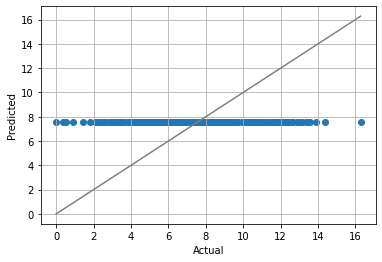

In [7]:
print('y_train 의 평균 : ', y_train.mean())
reg_plot(y_train, pred_train)

### (4)복잡도를 증가시켜가며 모델을 만들고 그림을 그려봅시다.

* 300,100,30,10,5,4,3,2,1
* k=가 1일때 가장 복잡한 모델!

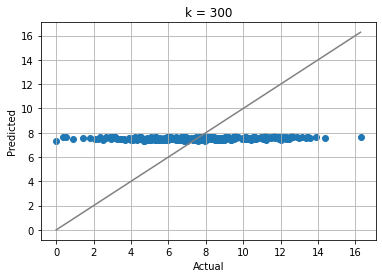

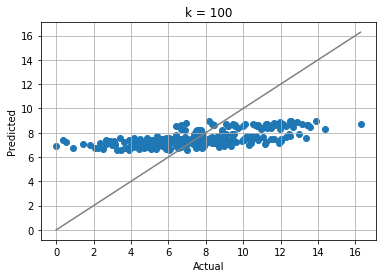

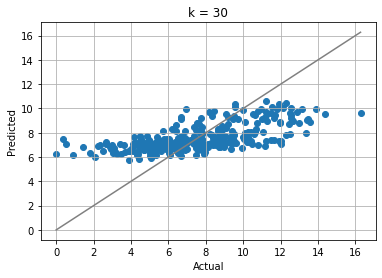

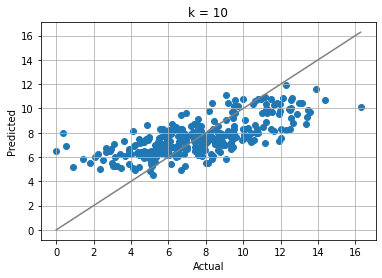

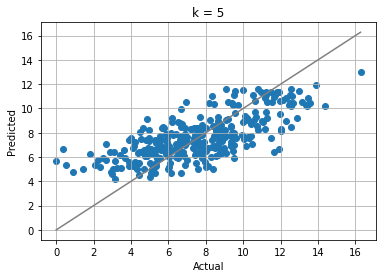

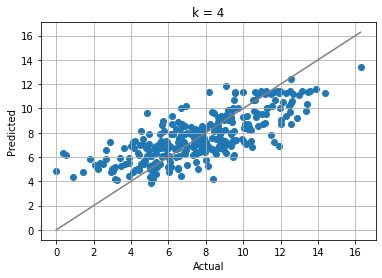

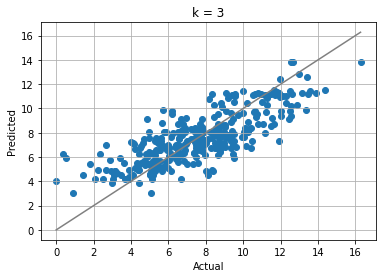

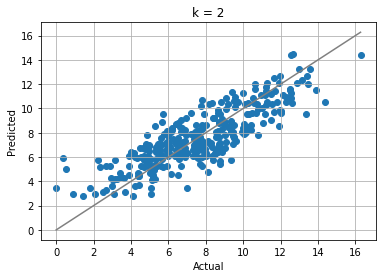

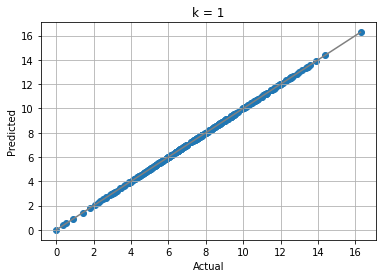

In [8]:
# 아래 90의 숫자를 줄여가며 모델링을 수행해 봅시다.
for n in [300,100,30,10,5,4,3,2,1] :
    model = KNeighborsRegressor(n_neighbors = n) # train set의 행 수
    model.fit(x_train_s, y_train)
    pred = model.predict(x_train_s)

    # 결과 plotting
    reg_plot(y_train, pred, f'k = {n}')
    plt.show()

### (5) 실습 : Decision Tree

* Decision Tree는 max_depth 값이 클 수록 복잡한 모델이 됩니다. 
* max_depth 값을 1부터 20까지 1씩 증가시켜가면서 역시 plot을 그려봅시다.


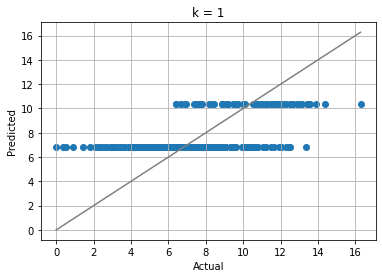

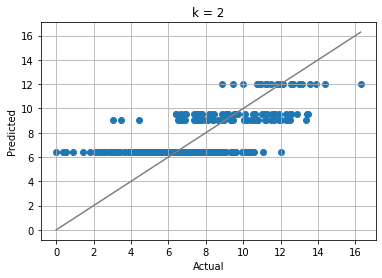

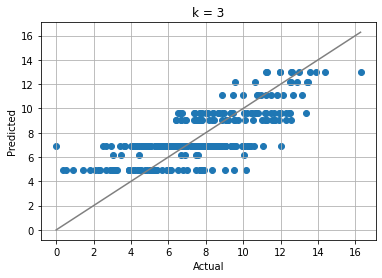

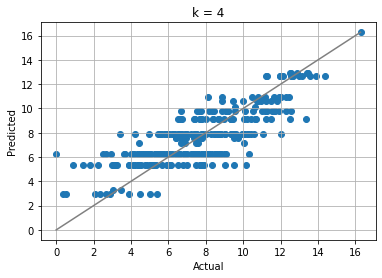

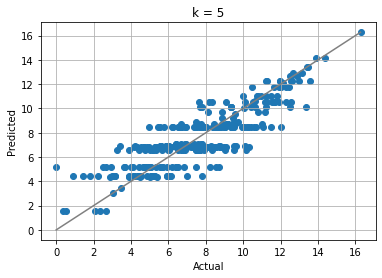

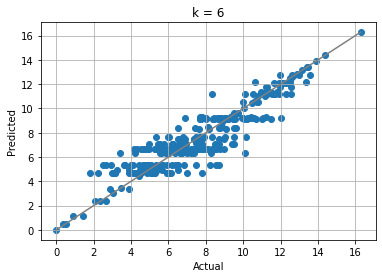

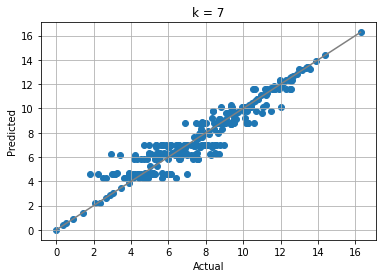

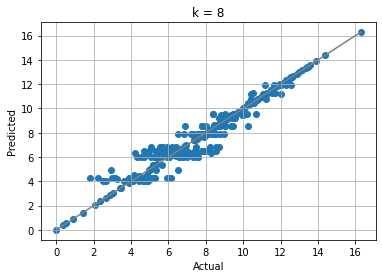

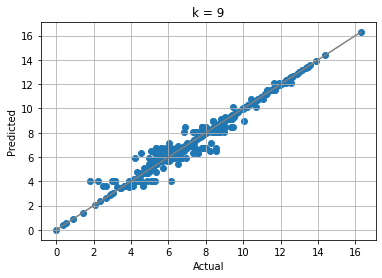

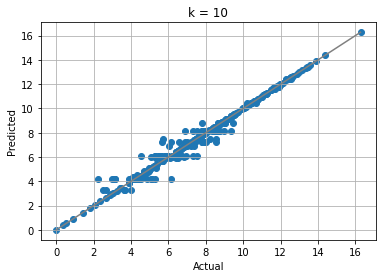

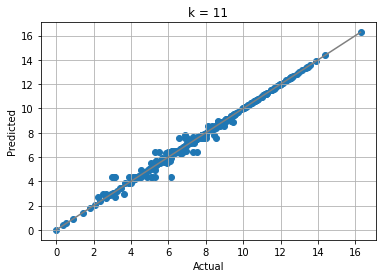

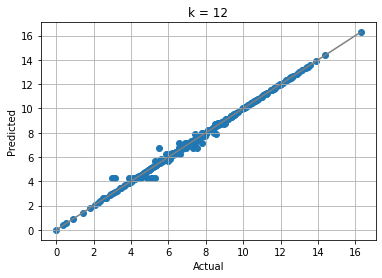

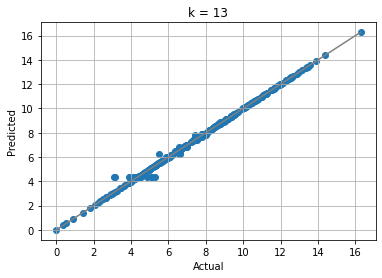

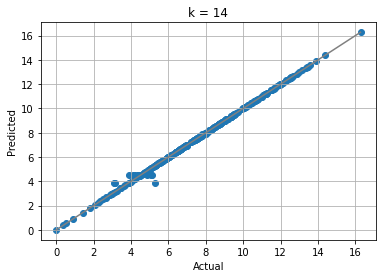

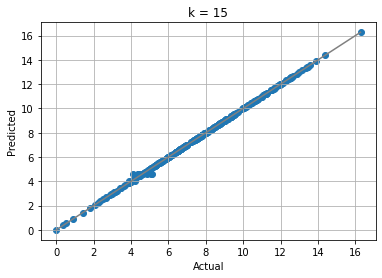

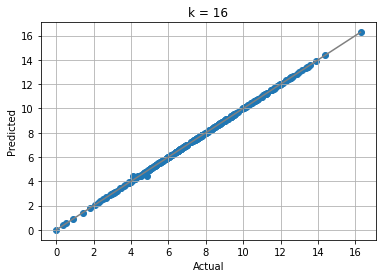

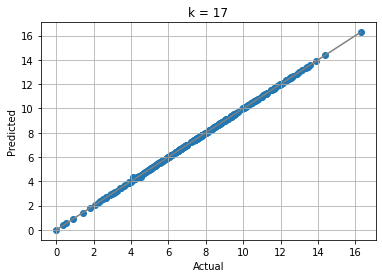

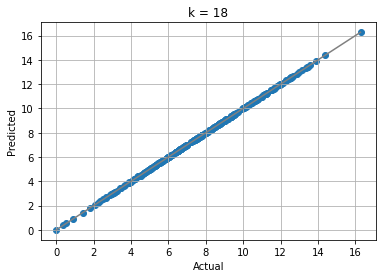

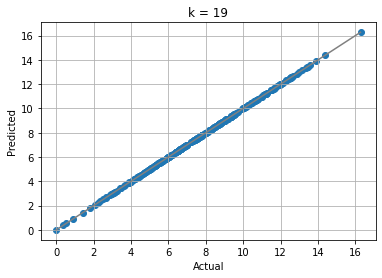

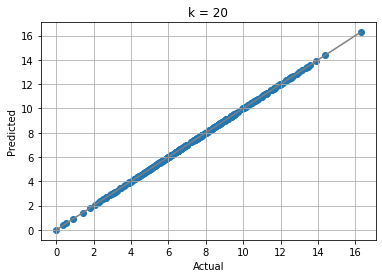

In [10]:
for n in range(1, 21) :
    model = DecisionTreeRegressor(max_depth= n)
    model.fit(x_train, y_train)
    pred = model.predict(x_train)

    # 결과 plotting
    reg_plot(y_train, pred, f'k = {n}')
    plt.show()

## 2.복잡도와 과적합

### (1) 데이터 준비

In [11]:
# mobile data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv"
data = pd.read_csv(path)
data = data.sample(5000, random_state = 2022)
data.drop(['id', 'REPORTED_USAGE_LEVEL','OVER_15MINS_CALLS_PER_MONTH'], axis = 1, inplace = True)
data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,CONSIDERING_CHANGE_OF_PLAN,CHURN
3178,0,119512,51,31,248566,229,2,very_sat,considering,LEAVE
14926,1,142144,192,15,774317,581,4,unsat,never_thought,LEAVE
15116,1,142308,0,79,306426,497,1,sat,considering,STAY
12733,1,113385,0,0,333599,819,6,very_unsat,considering,LEAVE
14032,1,90348,209,10,637286,360,4,unsat,actively_looking_into_it,STAY


|변수 명|내용|구분|
|	----	|	----	|	----	|
|	COLLEGE	|	대학졸업 여부(1,0) - 범주	|		|
|	INCOME	|	연 수입액(달러)	|		|
|	OVERAGE	|	월 초과사용 시간(분)	|		|
|	LEFTOVER	|	월 사용 잔여시간비율(%)	|		|
|	HOUSE	|	집 가격(달러)	|		|
|	HANDSET_PRICE	|	핸드폰 가격(달러)	|		|
|	AVERAGE_CALL_DURATION	|	평균 통화시간(분)	|		|
|	REPORTED_SATISFACTION	|	만족도 설문('very_unsat', 'unsat', 'avg', 'sat', 'very_sat' ) - 범주	|		|
|	CONSIDERING_CHANGE_OF_PLAN	|	변경 계획 설문('never_thought', 'no', 'perhaps', 'considering',   'actively_looking_into_it') - 범주	|		|
|	**CHURN**	|	이탈여부(1 : 이탈, 0 : 잔류)	|	**Target**	|


In [12]:
# 데이터분할1
target = 'CHURN'
x = data.drop(target, axis=1)
y = data.loc[:, target]

# 가변수화
dumm_cols = ['REPORTED_SATISFACTION','CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

# 데이터 분할2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2
                                                  , random_state = 2022)

# 스케일링
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

### (2) Fitting Graph 그리기

* 모델의 복잡도를 증가시켜가면서
* train & validation set에 대해 예측 및 평가를 수행하고,
* 결과를 그래프로 그리기

* Decision Tree
    * Decision Tree는 나무의 크기가 클 수록 복잡한 모델
    * 크기를 결정하는 파라미터는 max_depth

In [13]:
result_train = [] # train set을 가지고 예측한 결과
result_val = [] # val set을 가지고 예측한 결과
depth = list(range(1,21))

for d in depth :
    model = DecisionTreeClassifier(max_depth = d)
    model.fit(x_train, y_train)
    pred_tr, pred_val = model.predict(x_train), model.predict(x_val)
    result_train.append(accuracy_score(y_train, pred_tr))
    result_val.append(accuracy_score(y_val, pred_val))

In [14]:
pd.DataFrame({'max_depth': list(range(1,21)),'train_acc':result_train, 'val_acc':result_val})

,max_depth,train_acc,val_acc
0,1,0.61750,0.627
1,2,0.65400,0.679
2,3,0.69475,0.697
3,4,0.70775,0.690
4,5,0.72100,0.692
5,6,0.73700,0.680
6,7,0.75100,0.673
7,8,0.77050,0.667
8,9,0.79025,0.667
9,10,0.81750,0.662


정분류율은 몇 %인가요?  
값이 달라지나요? 값이 달라지는 원인은 무엇인가요?   
값이 달라진다면 모델의 성능을 어떻게 믿을 수 있을까요?  

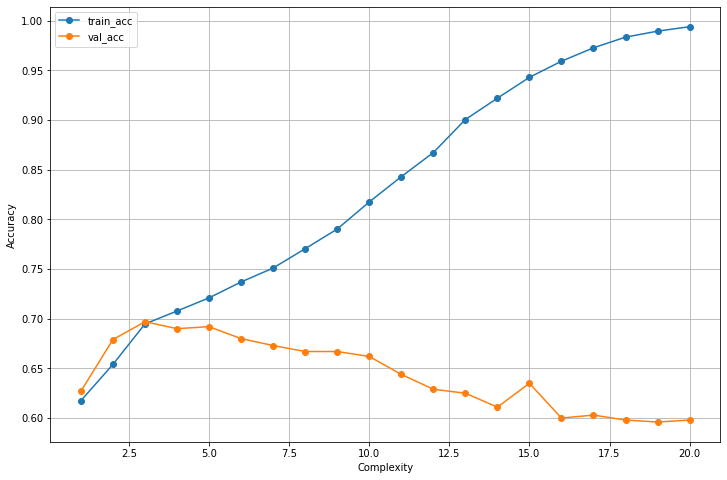

In [15]:
plt.figure(figsize = (12,8))
plt.plot(depth, result_train, label = 'train_acc', marker = 'o')
plt.plot(depth, result_val, label = 'val_acc', marker = 'o')

plt.xlabel('Complexity')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

* 최적의 depth는?

In [ ]:
# val_score가 떨어지기 전 최고점인 3

### (3) 실습 : KNN 알고리즘에 대해서 Fitting Graph를 그리시오.
* 실습1의 코드를 이용하되, knn 알고리즘을 이용
* k값을 1~100까지 증가시키면서 train / val 정확도를 측정하고
* fitting graph를 그리시오


In [17]:
result_train2 = [] # train set을 가지고 예측한 결과
result_val2 = [] # val set을 가지고 예측한 결과

for k in range(1, 101) :
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(x_train_s, y_train)
    pred_tr, pred_val = model.predict(x_train_s), model.predict(x_val_s)
    result_train2.append(accuracy_score(y_train, pred_tr))
    result_val2.append(accuracy_score(y_val, pred_val))

In [19]:
pd.DataFrame({'n_neighbors': list(range(1,101)),'train_acc':result_train2, 'val_acc':result_val2})

,n_neighbors,train_acc,val_acc
0,1,1.00000,0.587
1,2,0.79200,0.572
2,3,0.79400,0.618
3,4,0.74675,0.608
4,5,0.74800,0.622
...,...,...,...
95,96,0.62325,0.614
96,97,0.62075,0.619
97,98,0.62350,0.606
98,99,0.62150,0.611


* 최적의 k 값은?

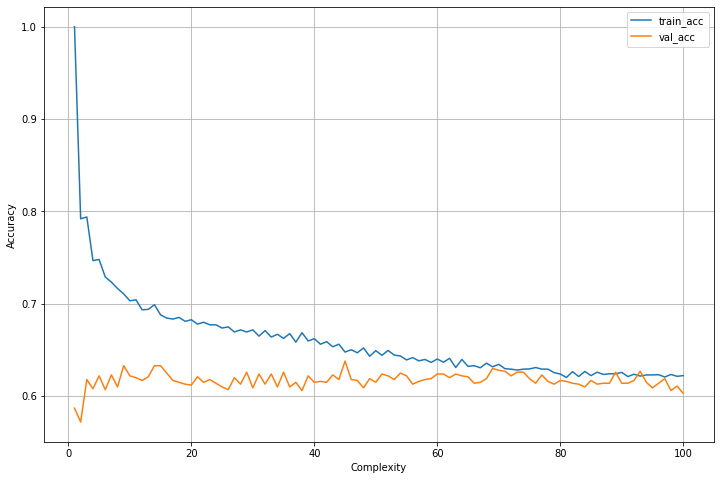

In [21]:
plt.figure(figsize = (12,8))
plt.plot(range(1, 101), result_train2, label = 'train_acc')
plt.plot(range(1, 101), result_val2, label = 'val_acc')

plt.xlabel('Complexity')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()